In [1]:
from keras.optimizers import *
from collections import defaultdict
import core.history as ch
import core.fine_model as cm
from core.fine_model import FineModel

import cr_interface as cri
import keras_utils as ku

import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from vis.visualization import visualize_cam, overlay

import math
import os

Using TensorFlow backend.


## Load Model

In [2]:
models = FineModel.get_dict()
models.keys()
#dict_keys(['xception', 'mobileneta25', 'mobilenetv2a35', 'vgg16', 'resnet50v2',
#'inception_v3','inception_resnet_v2', 'densenet121', 'nasnet_mobile'])
fm = models['mobileneta25']()

## Load Weights

In [3]:
depth = len(fm.depths) - 1
fm = models['mobileneta25']()
fm.get_model()
fm.load_weights('D{:02d}'.format(depth))
fm.compile_model()

Loading model mobileneta25... complete!
Loading weights from /Users/itsnamgyu/Source/cardiac-research/core/.fine_model_weights/mobileneta25/D06.hd5...complete!


## Visualized Grad-CAM Heatmap

In [10]:
def get_predictions(percentage_lists):
    predictions = []
    for percentages in percentage_lists:
        max_p = 0
        max_i = 0
        for i, p in enumerate(percentages):
            if p > max_p:
                max_i = i
                max_p = p
        predictions.append(max_i)
    return predictions

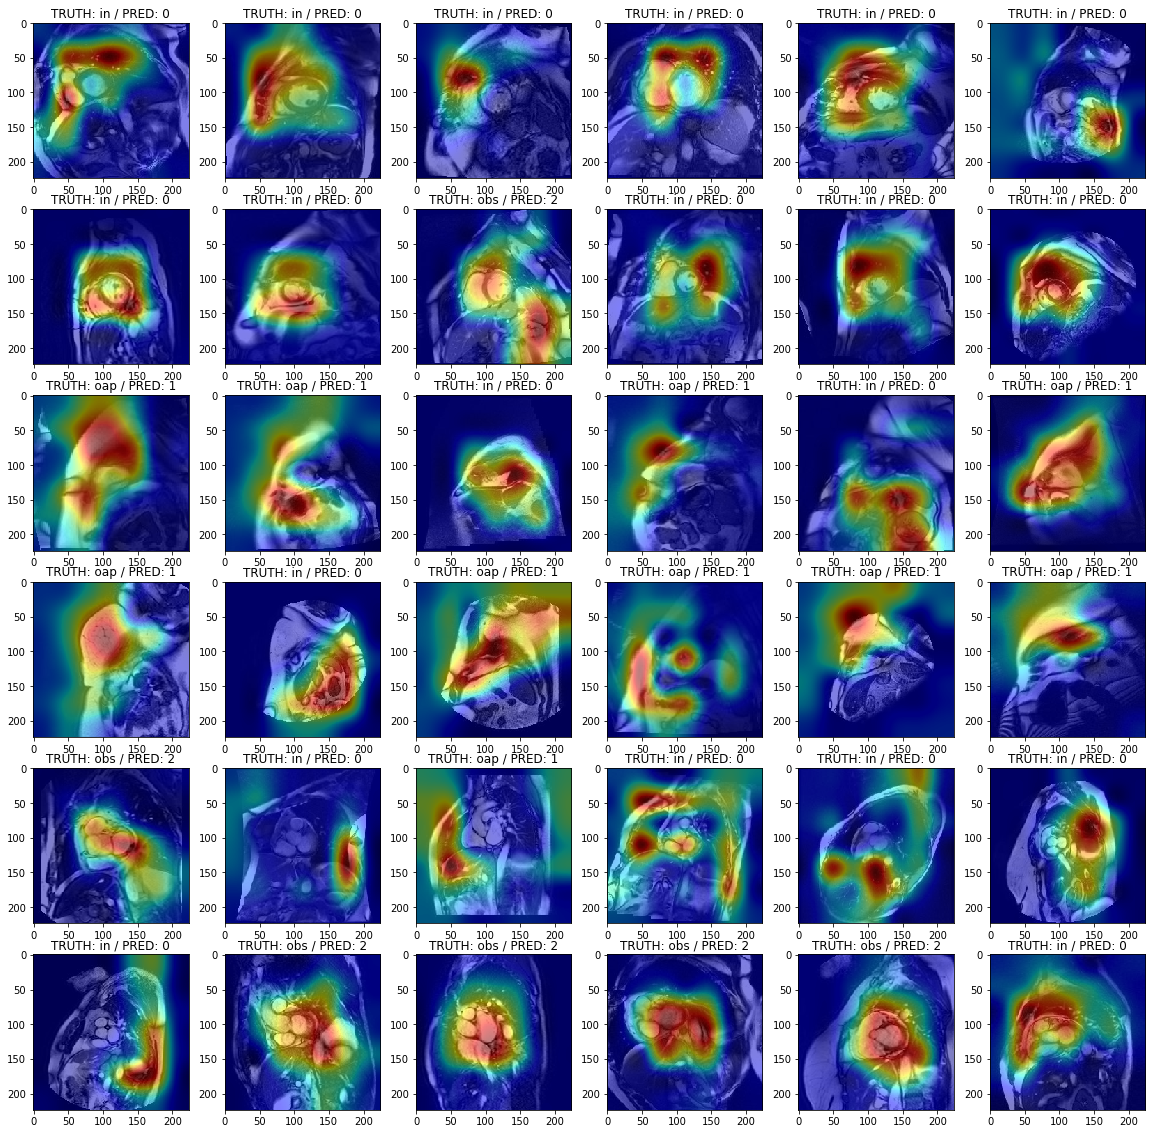

In [14]:
layer_idx = fm.depths[0]  # fc
penultimate_layer = fm.depths[0] - 2  # fc - pooling - last
pure_gen = fm.get_image_data_generator(augment=False)

f, ax = plt.subplots(6, 6, figsize=(20, 20))
ax = ax.flatten()

samples = 12
labels = ['in', 'oap', 'obs']

for label_index, label in enumerate(labels):
    images = cri.CrCollection.load()
    images = images.tri_label().filter_by(dataset_index=0, label=label)
    images = images.labeled().sample(samples)
    cr_codes = images.get_cr_codes()
    images = images.load_images(stack=True, target_size=fm.get_output_shape())
    
    preprocess = fm._get_preprocess_func()
    processed = []
    for image in images:
        processed.append(preprocess(image))
    processed = np.stack(processed)
    
    dirname = 'heatmap_{}_{}'.format(fm.get_name(), label)

    percentage_lists = fm.get_model().predict(processed)
    predictions = get_predictions(percentage_lists)
    
    for i, image in enumerate(images):
        prediction = predictions[i]
        p_label = labels[prediction]
        cr_code = cr_codes[i]
        grads = visualize_cam(fm.get_model(), layer_idx, filter_indices=prediction,
                              seed_input=processed[i], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None)        
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        final = overlay(grads, image)
        os.makedirs(dirname, exist_ok=True)
        ax[label_index * samples + i].imshow(final)
        ax[label_index * samples + i].set_title('TRUTH: {} / PRED: {}'.format(p_label, prediction))
        path = os.path.join(dirname, '{:02}_{}_{}.png'.format(i, label, cr_code))
        mpl.image.imsave(path, final)
        path = os.path.join(dirname, '{:02}_{}_{}_original.png'.format(i, label, cr_code))
        mpl.image.imsave(path, image)